# 🎙️ Fase 1: Análisis Visual de Señales Acústicas
## Proyecto Final - Dígitos Hablados (0-9)

Este notebook te permite:
- 🔍 **Comparar múltiples audios del mismo dígito** (de diferentes hablantes)
- ⚖️ **Comparar dos dígitos diferentes** 
- 📊 Visualizar señales de audio en tiempo y frecuencia
- 📈 Analizar características acústicas (FFT, Espectrograma, MFCC)
- 🎨 Gráficos profesionales y modernos

**Formato de archivos esperado:** `digito_hablante_archivo.wav` (ej: `9_03_14.wav`)

**Uso:** Ejecuta el menú principal con `menu_principal(DATA_DIR)`

---

## 📦 1. Configuración e Importación de Librerías

Instalación (si es necesario):
```bash
pip install numpy scipy librosa matplotlib pandas soundfile
```


In [2]:
# Importar librerías necesarias
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from pathlib import Path
import pandas as pd
import soundfile as sf
import random
from datetime import datetime
from IPython.display import Audio, display, Markdown
import warnings
import re
warnings.filterwarnings('ignore')

# Configuración de matplotlib para gráficos más bonitos y profesionales
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('default')

# Personalización avanzada del estilo
plt.rcParams['figure.figsize'] = (15, 4)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = '#f8f9fa'
plt.rcParams['axes.edgecolor'] = '#adb5bd'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'white'
plt.rcParams['grid.linewidth'] = 1.5
plt.rcParams['grid.alpha'] = 0.9
plt.rcParams['font.size'] = 11
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlepad'] = 15
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['legend.framealpha'] = 0.9
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

# Paleta de colores moderna
COLORS = {
    'primary': '#2563eb',    # Azul moderno
    'secondary': '#f97316',  # Naranja
    'success': '#10b981',    # Verde
    'danger': '#ef4444',     # Rojo
    'warning': '#f59e0b',    # Amarillo
    'info': '#06b6d4',       # Cyan
    'purple': '#8b5cf6',     # Púrpura
    'pink': '#ec4899'        # Rosa
}

print("✅ Librerías importadas correctamente")
print(f"📅 Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🎨 Estilo de gráficos: Moderno y profesional")


✅ Librerías importadas correctamente
📅 Fecha: 2025-10-23 09:48:38
🎨 Estilo de gráficos: Moderno y profesional


## 📂 2. Configuración de Rutas

Ajusta la ruta `DATA_DIR` según tu configuración:
- Ruta relativa: `data` 
- Ruta absoluta: `/ruta/completa/a/tu/carpeta/data`


In [3]:
# Configuración de rutas
DATA_DIR = Path("data")  # Carpeta con subcarpetas 01, 02, ..., 60
LOG_CSV = "labels_log.csv"

# Verificar que la carpeta existe
if DATA_DIR.exists():
    subdirs = sorted([d for d in DATA_DIR.iterdir() if d.is_dir()])
    print(f"✅ Carpeta encontrada: {DATA_DIR.absolute()}")
    print(f"📁 Subcarpetas detectadas: {len(subdirs)}")
    print(f"   Ejemplo: {subdirs[:5] if len(subdirs) >= 5 else subdirs}")
else:
    print(f"❌ ERROR: No se encontró la carpeta {DATA_DIR.absolute()}")
    print("   Ajusta la variable DATA_DIR")


✅ Carpeta encontrada: /Users/jesusmejia/google/uis/discretas/data
📁 Subcarpetas detectadas: 57
   Ejemplo: [PosixPath('data/01'), PosixPath('data/02'), PosixPath('data/03'), PosixPath('data/04'), PosixPath('data/06')]


## 🛠️ 3. Funciones de Análisis Acústico

Estas funciones calculan y visualizan las características de los audios.

**Nota:** El dígito se extrae automáticamente del nombre del archivo.
- Formato esperado: `digito_hablante_archivo.wav` (ejemplo: `9_03_14.wav` = dígito 9)


In [4]:
def extract_digit_from_filename(filename):
    """
    Extrae el dígito del nombre del archivo
    Formato esperado: digito_hablante_archivo.wav
    Ejemplo: 9_03_14.wav -> retorna 9
    
    Args:
        filename: Nombre del archivo (string o Path)
    
    Returns:
        int: Dígito extraído (0-9) o None si no se puede extraer
    """
    try:
        # Obtener solo el nombre del archivo sin la ruta
        name = Path(filename).name
        # Extraer el primer número antes del primer _
        match = re.match(r'^(\d+)_', name)
        if match:
            digit = int(match.group(1))
            if 0 <= digit <= 9:
                return digit
        return None
    except:
        return None


def extract_features(audio_path):
    """
    Extrae características acústicas de un archivo de audio
    
    Retorna:
        dict con: y (señal), sr (sample rate), duración, RMS, ZCR, centroid
    """
    # Cargar audio
    y, sr = librosa.load(audio_path, sr=None)
    
    # Características temporales
    duration = librosa.get_duration(y=y, sr=sr)
    rms = np.sqrt(np.mean(y**2))  # Root Mean Square (energía)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))  # Zero Crossing Rate
    
    # Características espectrales
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
    centroid = np.mean(spectral_centroids)
    
    return {
        'y': y,
        'sr': sr,
        'duration': duration,
        'rms': rms,
        'zcr': zcr,
        'centroid': centroid,
        'path': str(audio_path)
    }


def plot_waveform(y, sr, title="Forma de Onda"):
    """Grafica la forma de onda en el dominio del tiempo"""
    fig, ax = plt.subplots(figsize=(15, 4))
    time = np.linspace(0, len(y)/sr, len(y))
    ax.plot(time, y, color=COLORS['primary'], linewidth=1.5, alpha=0.8)
    ax.fill_between(time, y, alpha=0.2, color=COLORS['primary'])
    ax.set_xlabel('Tiempo (s)', fontweight='bold')
    ax.set_ylabel('Amplitud', fontweight='bold')
    ax.set_title(title, pad=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()


def plot_fft(y, sr, title="Transformada de Fourier (FFT)"):
    """Grafica el espectro de frecuencias usando FFT"""
    fig, ax = plt.subplots(figsize=(15, 4))
    
    # Calcular FFT
    N = len(y)
    yf = fft(y)
    xf = fftfreq(N, 1/sr)
    
    # Solo frecuencias positivas
    positive_freqs = xf[:N//2]
    magnitude = 2.0/N * np.abs(yf[:N//2])
    
    ax.plot(positive_freqs, magnitude, color=COLORS['secondary'], linewidth=1.8, alpha=0.9)
    ax.fill_between(positive_freqs, magnitude, alpha=0.25, color=COLORS['secondary'])
    ax.set_xlabel('Frecuencia (Hz)', fontweight='bold')
    ax.set_ylabel('Magnitud', fontweight='bold')
    ax.set_title(title, pad=15)
    ax.set_xlim(0, sr//2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()


def plot_spectrogram(y, sr, title="Espectrograma (STFT)"):
    """Grafica el espectrograma (tiempo-frecuencia)"""
    fig, ax = plt.subplots(figsize=(15, 5))
    
    # Calcular espectrograma
    D = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    
    img = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', 
                                    cmap='inferno', ax=ax)
    cbar = plt.colorbar(img, ax=ax, format='%+2.0f dB')
    cbar.set_label('Intensidad (dB)', rotation=270, labelpad=20, fontweight='bold')
    ax.set_xlabel('Tiempo (s)', fontweight='bold')
    ax.set_ylabel('Frecuencia (Hz)', fontweight='bold')
    ax.set_title(title, pad=15)
    plt.tight_layout()
    plt.show()


def plot_mfcc(y, sr, title="Coeficientes MFCC"):
    """Grafica los coeficientes MFCC (Mel-Frequency Cepstral Coefficients)"""
    fig, ax = plt.subplots(figsize=(15, 5))
    
    # Calcular MFCC (13 coeficientes por defecto)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    
    img = librosa.display.specshow(mfccs, sr=sr, x_axis='time', 
                                    cmap='RdYlBu_r', ax=ax)
    cbar = plt.colorbar(img, ax=ax)
    cbar.set_label('Coeficiente', rotation=270, labelpad=20, fontweight='bold')
    ax.set_xlabel('Tiempo (s)', fontweight='bold')
    ax.set_ylabel('Coeficiente MFCC', fontweight='bold')
    ax.set_title(title, pad=15)
    plt.tight_layout()
    plt.show()


def analyze_audio(audio_path):
    """
    Función principal: analiza completamente un audio
    Muestra todas las visualizaciones y retorna las características
    """
    print(f"\n{'='*80}")
    print(f"🎵 Analizando: {audio_path}")
    print(f"{'='*80}\n")
    
    # Extraer características
    features = extract_features(audio_path)
    
    # Mostrar información básica
    print(f"📊 Características básicas:")
    print(f"   • Duración: {features['duration']:.3f} segundos")
    print(f"   • Sample Rate: {features['sr']} Hz")
    print(f"   • RMS (energía): {features['rms']:.6f}")
    print(f"   • Zero Crossing Rate: {features['zcr']:.6f}")
    print(f"   • Spectral Centroid: {features['centroid']:.2f} Hz")
    print()
    
    # Reproducir audio
    print("🎧 Reproduciendo audio...")
    display(Audio(features['y'], rate=features['sr']))
    print()
    
    # Visualizaciones
    print("📈 Generando visualizaciones...\n")
    
    plot_waveform(features['y'], features['sr'], 
                  f"Forma de Onda - {Path(audio_path).name}")
    
    plot_fft(features['y'], features['sr'], 
             f"FFT - {Path(audio_path).name}")
    
    plot_spectrogram(features['y'], features['sr'], 
                     f"Espectrograma - {Path(audio_path).name}")
    
    plot_mfcc(features['y'], features['sr'], 
              f"MFCC - {Path(audio_path).name}")
    
    return features

print("✅ Funciones de análisis definidas correctamente")


✅ Funciones de análisis definidas correctamente


## 🎲 4. Sistema de Selección y Etiquetado

Puedes seleccionar audios aleatoriamente o elegir una carpeta específica.


In [5]:
def get_random_audio(data_dir, folder=None):
    """
    Obtiene un archivo de audio aleatorio
    
    Args:
        data_dir: Carpeta raíz con subcarpetas de audios
        folder: (opcional) Nombre de subcarpeta específica (ej: "01", "15")
    
    Returns:
        Path al archivo de audio seleccionado
    """
    if folder:
        target_dir = data_dir / folder
        if not target_dir.exists():
            print(f"❌ La carpeta {folder} no existe")
            return None
    else:
        # Elegir carpeta aleatoria
        subdirs = [d for d in data_dir.iterdir() if d.is_dir()]
        if not subdirs:
            print(f"❌ No se encontraron subcarpetas en {data_dir}")
            return None
        target_dir = random.choice(subdirs)
    
    # Elegir archivo aleatorio
    audio_files = list(target_dir.glob("*.wav"))
    if not audio_files:
        print(f"❌ No se encontraron archivos .wav en {target_dir}")
        return None
    
    return random.choice(audio_files)


def get_random_audio_by_digit(data_dir, digit):
    """
    Obtiene un audio aleatorio de un dígito específico
    
    Args:
        data_dir: Carpeta raíz con subcarpetas de audios
        digit: Dígito a buscar (0-9)
    
    Returns:
        Path al archivo o None si no se encuentra
    """
    # Buscar en todas las subcarpetas
    subdirs = [d for d in data_dir.iterdir() if d.is_dir()]
    
    # Encontrar todos los audios que comienzan con el dígito
    matching_files = []
    for subdir in subdirs:
        files = list(subdir.glob(f"{digit}_*.wav"))
        matching_files.extend(files)
    
    if not matching_files:
        return None
    
    return random.choice(matching_files)


def compare_same_digit_multiple(data_dir, digit, num_samples=5):
    """
    Compara múltiples audios del mismo dígito de diferentes hablantes
    
    Args:
        data_dir: Carpeta raíz con subcarpetas de audios
        digit: Dígito a comparar (0-9)
        num_samples: Número de muestras a comparar (default: 5)
    """
    print(f"\n{'='*80}")
    print(f"🔍 COMPARANDO {num_samples} MUESTRAS DEL DÍGITO: {digit}")
    print(f"{'='*80}\n")
    
    # Buscar todas las carpetas (hablantes)
    subdirs = sorted([d for d in data_dir.iterdir() if d.is_dir()])
    
    # Seleccionar carpetas aleatorias
    if len(subdirs) < num_samples:
        print(f"⚠️  Solo hay {len(subdirs)} carpetas disponibles")
        num_samples = len(subdirs)
    
    selected_folders = random.sample(subdirs, num_samples)
    
    # Buscar un audio del dígito en cada carpeta
    audio_paths = []
    for folder in selected_folders:
        files = list(folder.glob(f"{digit}_*.wav"))
        if files:
            audio_paths.append(random.choice(files))
    
    if len(audio_paths) < 2:
        print(f"❌ No se encontraron suficientes audios del dígito {digit}")
        print(f"   Solo se encontraron {len(audio_paths)} audio(s)")
        return
    
    print(f"✅ Se encontraron {len(audio_paths)} audios del dígito {digit}\n")
    
    # Analizar y comparar cada audio
    for i, audio_path in enumerate(audio_paths, 1):
        print(f"\n{'─'*80}")
        print(f"📊 AUDIO {i}/{len(audio_paths)}")
        print(f"{'─'*80}")
        print(f"📁 Carpeta: {audio_path.parent.name}")
        print(f"📄 Archivo: {audio_path.name}\n")
        
        features = extract_features(audio_path)
        
        # Mostrar características
        print(f"⏱️  Duración: {features['duration']:.3f} s")
        print(f"⚡ RMS: {features['rms']:.6f}")
        print(f"🔊 ZCR: {features['zcr']:.6f}")
        print(f"🎵 Centroid: {features['centroid']:.2f} Hz")
        
        # Reproducir audio
        print(f"\n🎧 Reproduciendo...")
        display(Audio(features['y'], rate=features['sr']))
        
        # Mostrar visualizaciones
        plot_waveform(features['y'], features['sr'], 
                     f"Forma de Onda - Audio {i} - {audio_path.name}")
        
        plot_fft(features['y'], features['sr'], 
                f"FFT - Audio {i} - {audio_path.name}")
        
        plot_spectrogram(features['y'], features['sr'], 
                        f"Espectrograma - Audio {i} - {audio_path.name}")
    
    print(f"\n{'='*80}")
    print(f"✅ COMPARACIÓN COMPLETADA")
    print(f"{'='*80}\n")


def compare_two_digits(data_dir, digit1, digit2):
    """
    Compara dos audios de dígitos diferentes
    
    Args:
        data_dir: Carpeta raíz con subcarpetas de audios
        digit1: Primer dígito (0-9)
        digit2: Segundo dígito (0-9)
    """
    print(f"\n{'='*80}")
    print(f"⚖️  COMPARANDO DÍGITO {digit1} vs DÍGITO {digit2}")
    print(f"{'='*80}\n")
    
    # Obtener audios aleatorios para cada dígito
    audio1 = get_random_audio_by_digit(data_dir, digit1)
    audio2 = get_random_audio_by_digit(data_dir, digit2)
    
    if audio1 is None:
        print(f"❌ No se encontraron audios del dígito {digit1}")
        return
    
    if audio2 is None:
        print(f"❌ No se encontraron audios del dígito {digit2}")
        return
    
    print(f"✅ Audios seleccionados:")
    print(f"   Dígito {digit1}: {audio1.name} (carpeta {audio1.parent.name})")
    print(f"   Dígito {digit2}: {audio2.name} (carpeta {audio2.parent.name})\n")
    
    # Extraer características
    features1 = extract_features(audio1)
    features2 = extract_features(audio2)
    
    # Tabla comparativa
    print(f"{'─'*80}")
    print(f"📊 TABLA COMPARATIVA")
    print(f"{'─'*80}\n")
    
    comparison_data = {
        'Característica': ['Duración (s)', 'RMS', 'ZCR', 'Centroid (Hz)'],
        f'Dígito {digit1}': [
            f"{features1['duration']:.3f}",
            f"{features1['rms']:.6f}",
            f"{features1['zcr']:.6f}",
            f"{features1['centroid']:.2f}"
        ],
        f'Dígito {digit2}': [
            f"{features2['duration']:.3f}",
            f"{features2['rms']:.6f}",
            f"{features2['zcr']:.6f}",
            f"{features2['centroid']:.2f}"
        ]
    }
    df_comp = pd.DataFrame(comparison_data)
    print(df_comp.to_string(index=False))
    print()
    
    # Reproducir audios
    print(f"🎧 Audio Dígito {digit1}:")
    display(Audio(features1['y'], rate=features1['sr']))
    print(f"\n🎧 Audio Dígito {digit2}:")
    display(Audio(features2['y'], rate=features2['sr']))
    print()
    
    # Gráficas comparativas
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))
    
    # Formas de onda
    time1 = np.linspace(0, features1['duration'], len(features1['y']))
    time2 = np.linspace(0, features2['duration'], len(features2['y']))
    
    axes[0].plot(time1, features1['y'], label=f'Dígito {digit1}', 
                 alpha=0.8, color=COLORS['primary'], linewidth=1.8)
    axes[0].plot(time2, features2['y'], label=f'Dígito {digit2}', 
                 alpha=0.8, color=COLORS['secondary'], linewidth=1.8)
    axes[0].set_xlabel('Tiempo (s)', fontweight='bold')
    axes[0].set_ylabel('Amplitud', fontweight='bold')
    axes[0].set_title(f'Comparación de Formas de Onda: Dígito {digit1} vs Dígito {digit2}', 
                      pad=15, fontweight='bold')
    axes[0].legend(loc='upper right', framealpha=0.9)
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)
    
    # FFT
    N1 = len(features1['y'])
    yf1 = fft(features1['y'])
    xf1 = fftfreq(N1, 1/features1['sr'])[:N1//2]
    mag1 = 2.0/N1 * np.abs(yf1[:N1//2])
    
    N2 = len(features2['y'])
    yf2 = fft(features2['y'])
    xf2 = fftfreq(N2, 1/features2['sr'])[:N2//2]
    mag2 = 2.0/N2 * np.abs(yf2[:N2//2])
    
    axes[1].plot(xf1, mag1, label=f'Dígito {digit1}', 
                 alpha=0.8, color=COLORS['primary'], linewidth=1.8)
    axes[1].plot(xf2, mag2, label=f'Dígito {digit2}', 
                 alpha=0.8, color=COLORS['secondary'], linewidth=1.8)
    axes[1].set_xlabel('Frecuencia (Hz)', fontweight='bold')
    axes[1].set_ylabel('Magnitud', fontweight='bold')
    axes[1].set_title(f'Comparación de FFT: Dígito {digit1} vs Dígito {digit2}', 
                      pad=15, fontweight='bold')
    axes[1].legend(loc='upper right', framealpha=0.9)
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    axes[1].set_xlim(0, min(features1['sr'], features2['sr'])//2)
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar espectrogramas individuales
    print(f"\n{'─'*80}")
    print("📊 ESPECTROGRAMAS INDIVIDUALES")
    print(f"{'─'*80}\n")
    
    plot_spectrogram(features1['y'], features1['sr'], 
                    f"Espectrograma del Dígito {digit1} - {audio1.name}")
    
    plot_spectrogram(features2['y'], features2['sr'], 
                    f"Espectrograma del Dígito {digit2} - {audio2.name}")
    
    print(f"\n{'='*80}")
    print(f"✅ COMPARACIÓN COMPLETADA")
    print(f"{'='*80}\n")


print("✅ Funciones de comparación configuradas")


✅ Funciones de comparación configuradas


## 🔍 4. Menú Principal de Comparación

Este menú te permite comparar audios de diferentes formas.


In [6]:
def menu_principal(data_dir):
    """
    Menú principal interactivo para comparar audios
    
    Args:
        data_dir: Carpeta raíz con subcarpetas de audios
    """
    while True:
        print(f"\n{'='*80}")
        print("🎙️  MENÚ PRINCIPAL - COMPARACIÓN DE AUDIOS")
        print(f"{'='*80}\n")
        print("Opciones disponibles:")
        print("  [1] 🔍 Comparar MÚLTIPLES audios del MISMO dígito (5 hablantes diferentes)")
        print("  [2] ⚖️  Comparar DOS dígitos DIFERENTES")
        print("  [3] ❌ Salir")
        print()
        
        opcion = input("Elige una opción (1-3): ").strip()
        
        if opcion == "1":
            # Opción 1: Comparar múltiples del mismo dígito
            print(f"\n{'─'*80}")
            try:
                digit = int(input("¿Qué dígito quieres comparar? (0-9): ").strip())
                if 0 <= digit <= 9:
                    compare_same_digit_multiple(data_dir, digit, num_samples=5)
                else:
                    print("❌ Dígito inválido. Debe ser entre 0 y 9.")
            except ValueError:
                print("❌ Por favor ingresa un número válido.")
                
        elif opcion == "2":
            # Opción 2: Comparar dos dígitos diferentes
            print(f"\n{'─'*80}")
            try:
                digit1 = int(input("Primer dígito (0-9): ").strip())
                digit2 = int(input("Segundo dígito (0-9): ").strip())
                
                if 0 <= digit1 <= 9 and 0 <= digit2 <= 9:
                    if digit1 == digit2:
                        print("⚠️  Los dígitos son iguales. Usa la opción 1 para comparar el mismo dígito.")
                    else:
                        compare_two_digits(data_dir, digit1, digit2)
                else:
                    print("❌ Dígitos inválidos. Deben ser entre 0 y 9.")
            except ValueError:
                print("❌ Por favor ingresa números válidos.")
                
        elif opcion == "3":
            # Salir
            print("\n👋 ¡Hasta luego!\n")
            break
            
        else:
            print("\n⚠️  Opción inválida. Por favor elige 1, 2 o 3.")


# Ejecutar el menú
print("✅ Menú principal configurado")
print("\n💡 Para iniciar el menú, ejecuta: menu_principal(DATA_DIR)")


✅ Menú principal configurado

💡 Para iniciar el menú, ejecuta: menu_principal(DATA_DIR)


---

# 🚀 EJECUTAR MENÚ PRINCIPAL

Ejecuta la siguiente celda para iniciar el menú interactivo de comparación:



🎙️  MENÚ PRINCIPAL - COMPARACIÓN DE AUDIOS

Opciones disponibles:
  [1] 🔍 Comparar MÚLTIPLES audios del MISMO dígito (5 hablantes diferentes)
  [2] ⚖️  Comparar DOS dígitos DIFERENTES
  [3] ❌ Salir


────────────────────────────────────────────────────────────────────────────────

🔍 COMPARANDO 5 MUESTRAS DEL DÍGITO: 7

✅ Se encontraron 5 audios del dígito 7


────────────────────────────────────────────────────────────────────────────────
📊 AUDIO 1/5
────────────────────────────────────────────────────────────────────────────────
📁 Carpeta: 27
📄 Archivo: 7_27_0.wav

⏱️  Duración: 0.635 s
⚡ RMS: 0.004928
🔊 ZCR: 0.043547
🎵 Centroid: 3244.32 Hz

🎧 Reproduciendo...


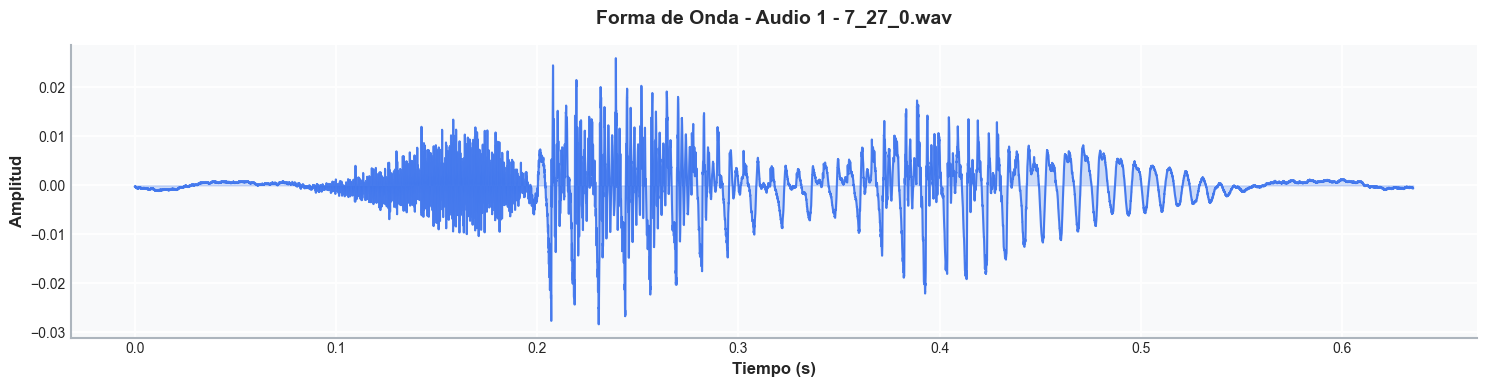

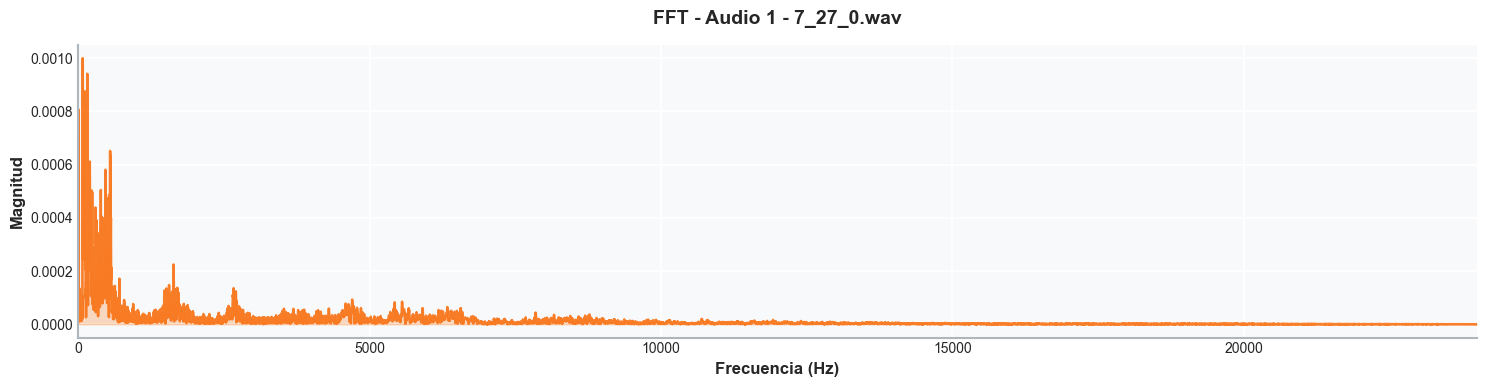

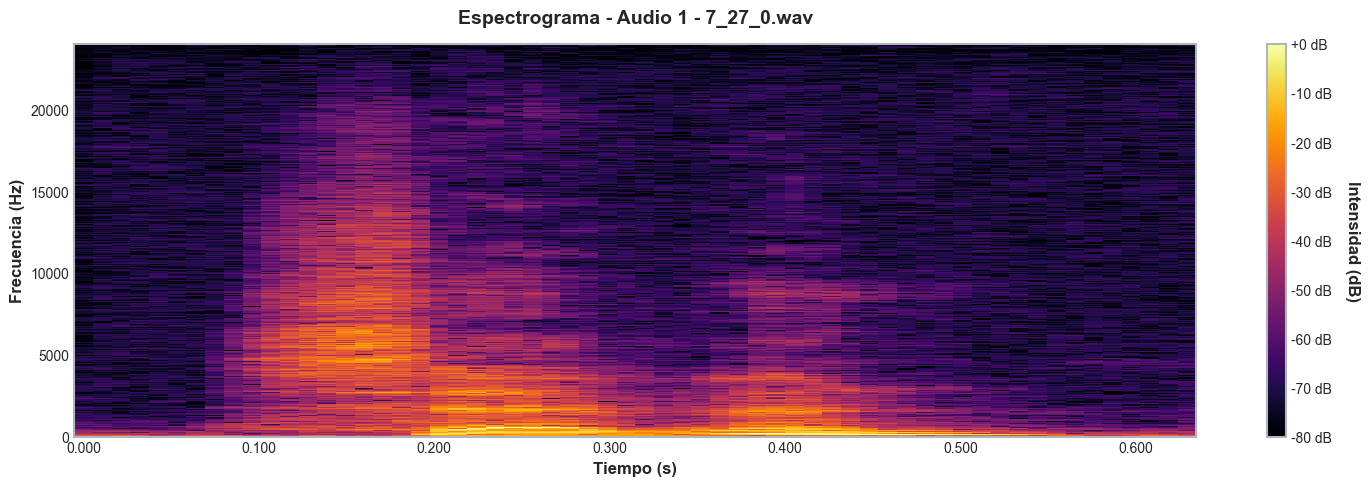


────────────────────────────────────────────────────────────────────────────────
📊 AUDIO 2/5
────────────────────────────────────────────────────────────────────────────────
📁 Carpeta: 35
📄 Archivo: 7_35_47.wav

⏱️  Duración: 0.716 s
⚡ RMS: 0.004302
🔊 ZCR: 0.094533
🎵 Centroid: 4422.43 Hz

🎧 Reproduciendo...


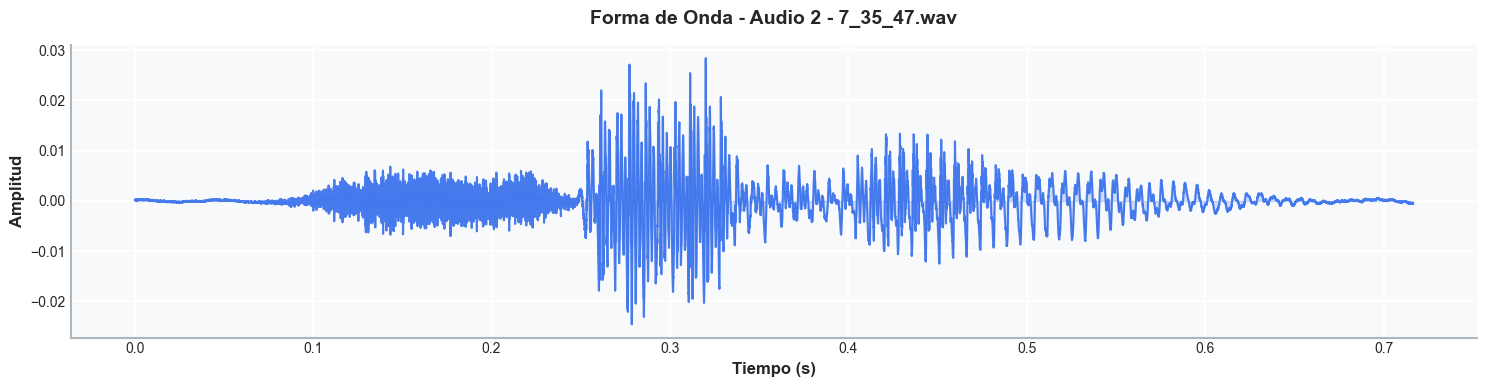

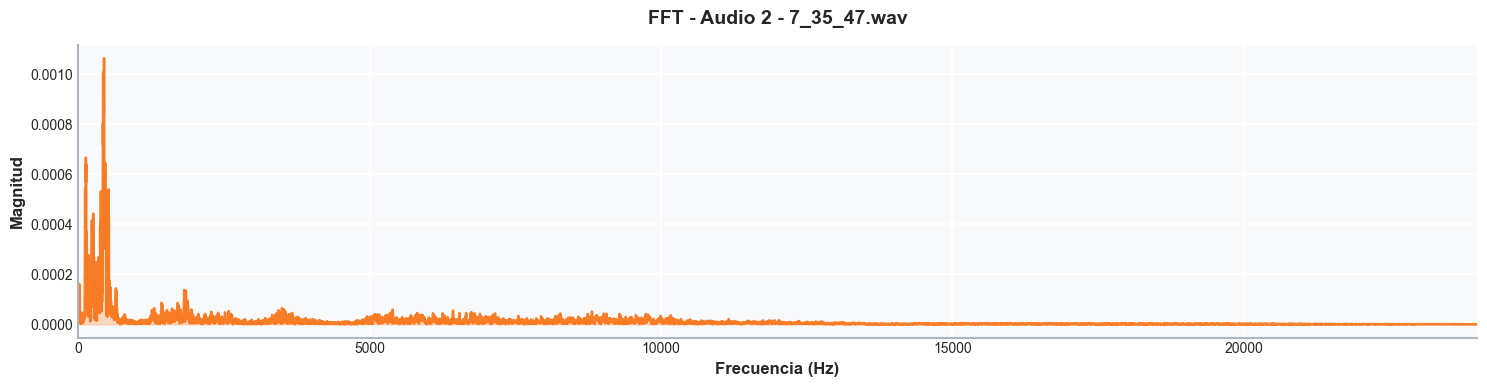

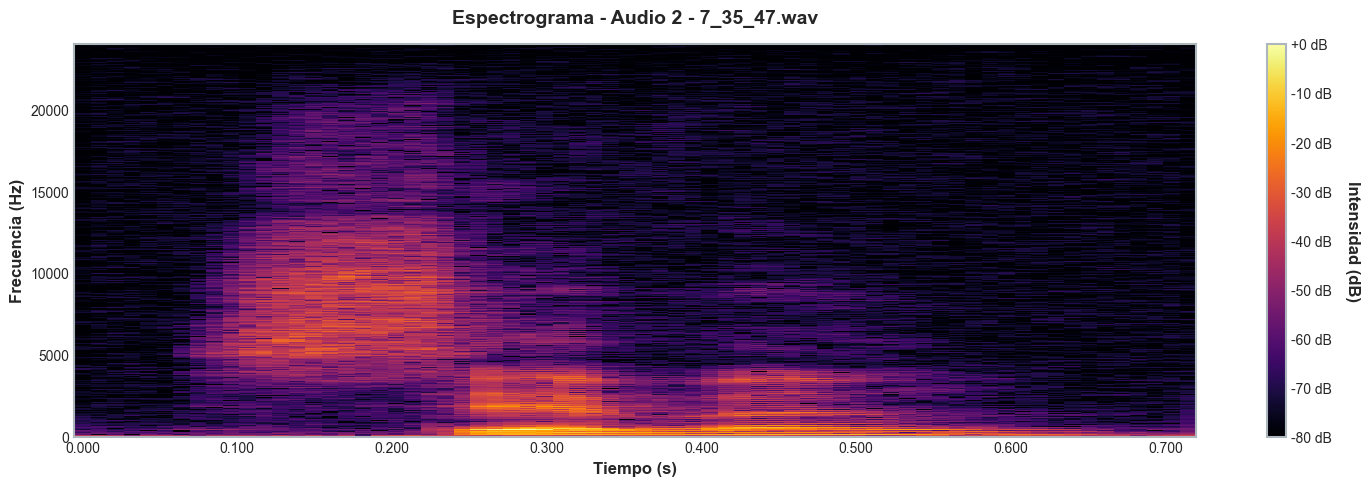


────────────────────────────────────────────────────────────────────────────────
📊 AUDIO 3/5
────────────────────────────────────────────────────────────────────────────────
📁 Carpeta: 17
📄 Archivo: 7_17_6.wav

⏱️  Duración: 0.779 s
⚡ RMS: 0.003157
🔊 ZCR: 0.062724
🎵 Centroid: 4658.21 Hz

🎧 Reproduciendo...


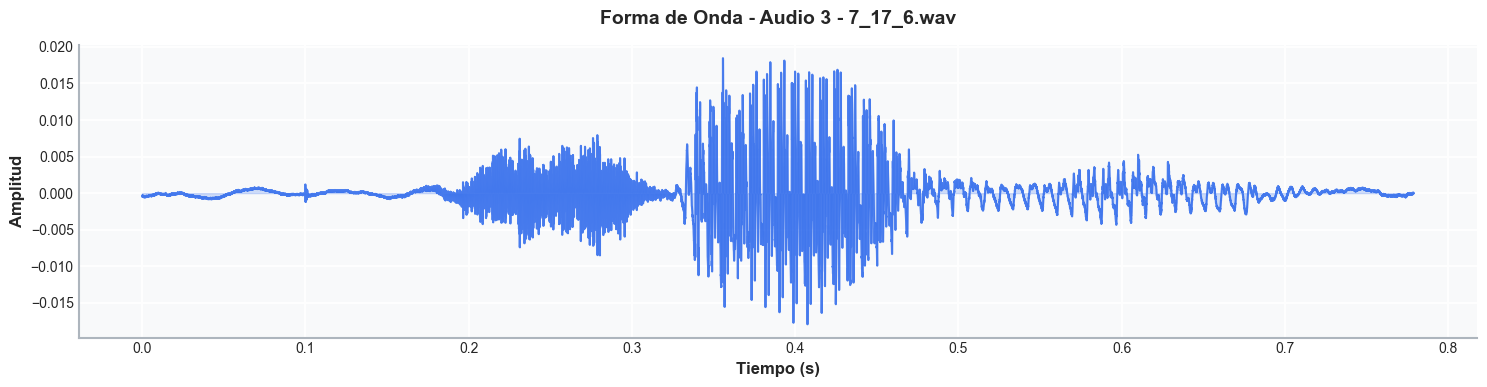

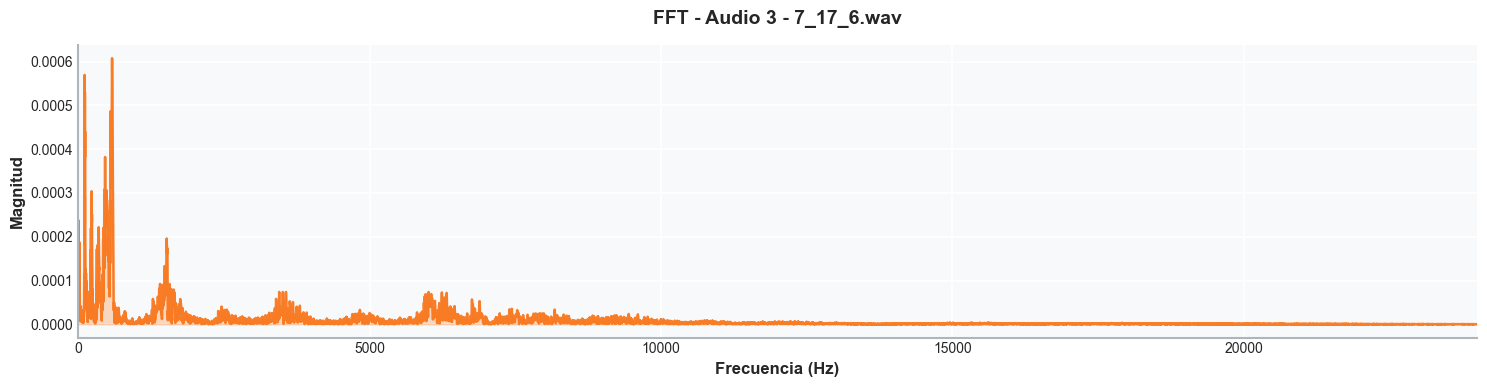

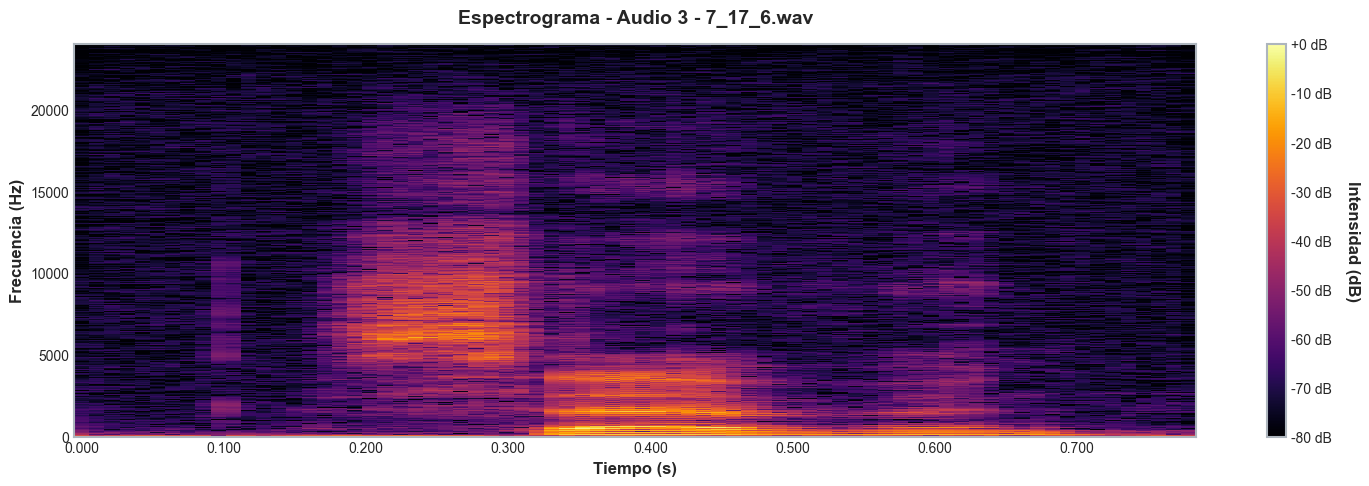


────────────────────────────────────────────────────────────────────────────────
📊 AUDIO 4/5
────────────────────────────────────────────────────────────────────────────────
📁 Carpeta: 38
📄 Archivo: 7_38_23.wav

⏱️  Duración: 0.716 s
⚡ RMS: 0.009338
🔊 ZCR: 0.054695
🎵 Centroid: 3286.78 Hz

🎧 Reproduciendo...


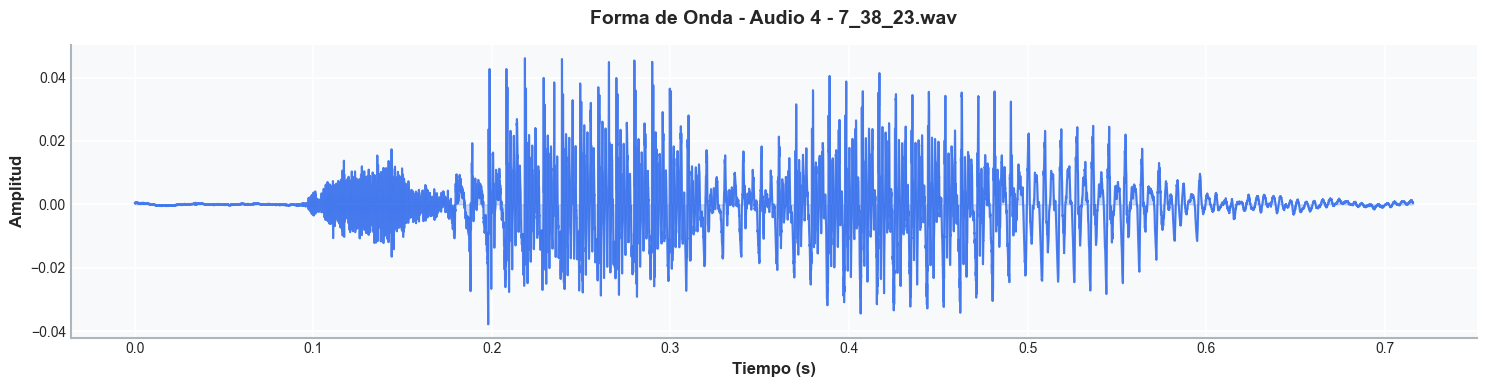

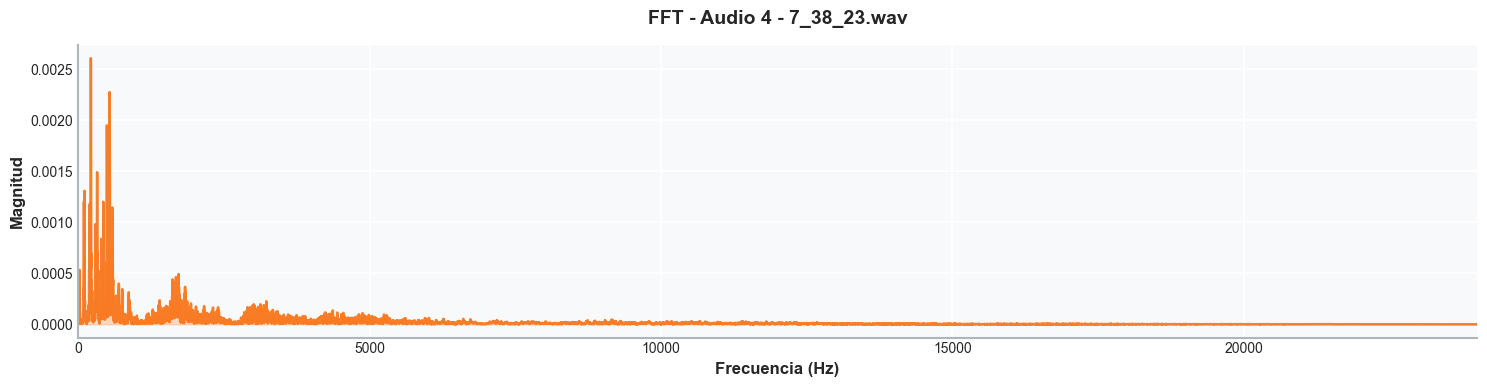

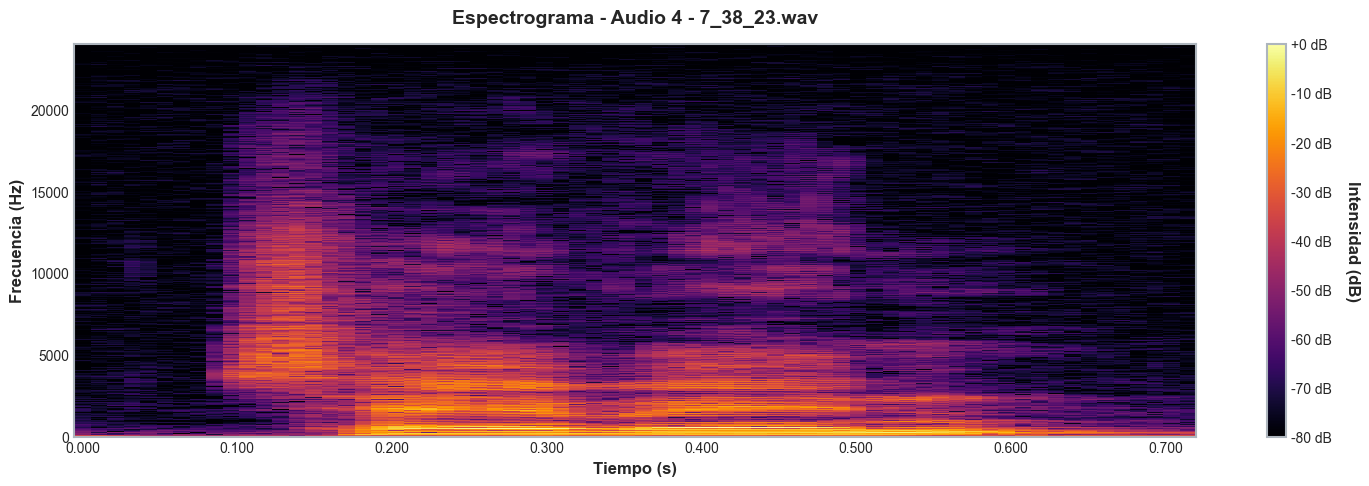


────────────────────────────────────────────────────────────────────────────────
📊 AUDIO 5/5
────────────────────────────────────────────────────────────────────────────────
📁 Carpeta: 50
📄 Archivo: 7_50_3.wav

⏱️  Duración: 0.759 s
⚡ RMS: 0.002392
🔊 ZCR: 0.037374
🎵 Centroid: 4065.24 Hz

🎧 Reproduciendo...


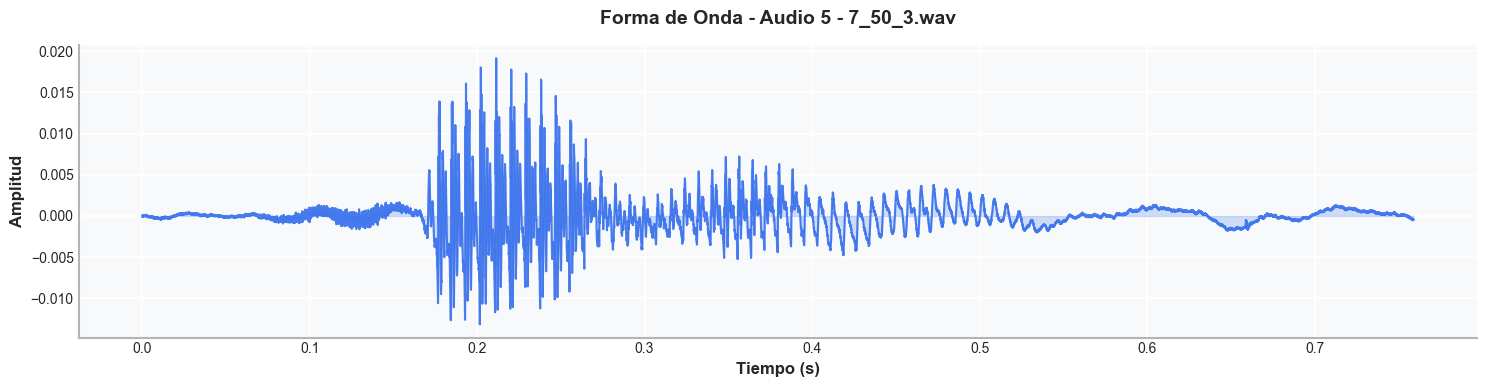

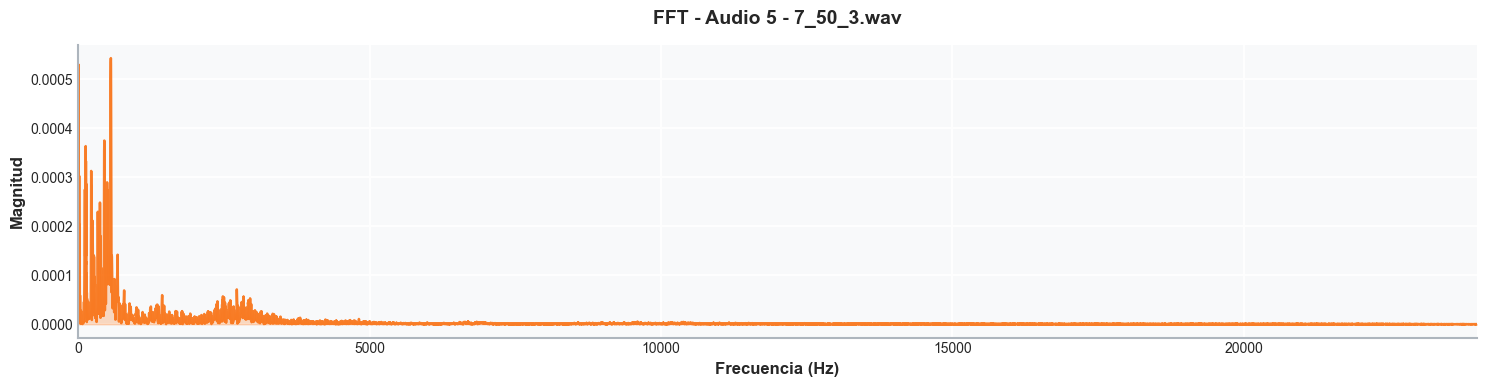

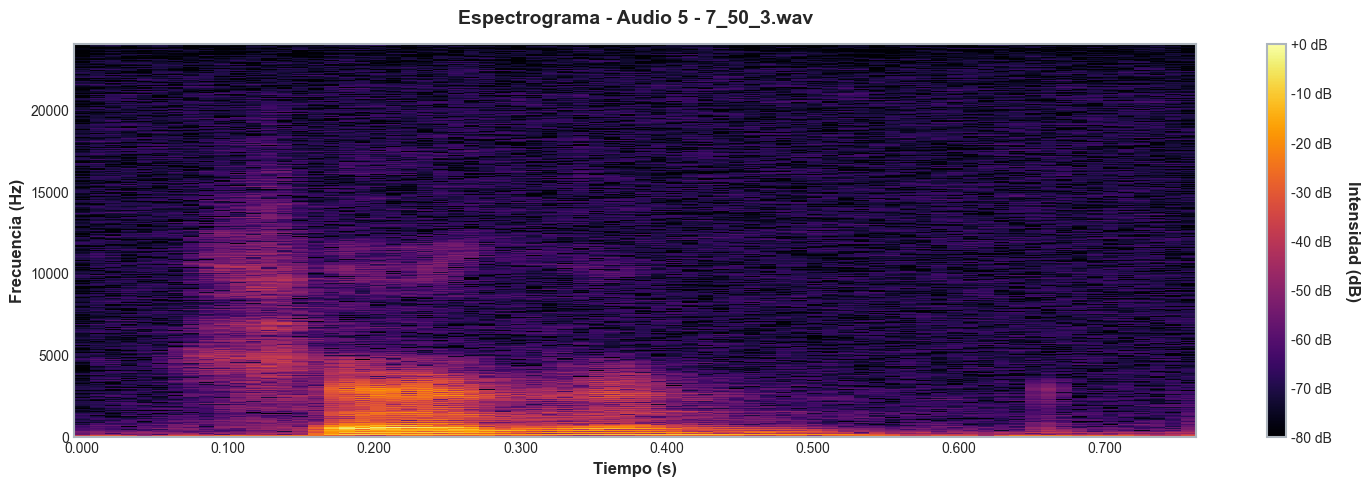


✅ COMPARACIÓN COMPLETADA


🎙️  MENÚ PRINCIPAL - COMPARACIÓN DE AUDIOS

Opciones disponibles:
  [1] 🔍 Comparar MÚLTIPLES audios del MISMO dígito (5 hablantes diferentes)
  [2] ⚖️  Comparar DOS dígitos DIFERENTES
  [3] ❌ Salir


👋 ¡Hasta luego!



In [7]:
# 🎙️ INICIAR MENÚ PRINCIPAL
# Este menú te permite elegir entre:
#   1. Comparar 5 audios del mismo dígito (diferentes hablantes)
#   2. Comparar dos dígitos diferentes

menu_principal(DATA_DIR)
